In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()

# Metrics
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

# ML Algos
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
#from statsmodels.tsa.arima_model import ARIMA

In [12]:
complete_data = pd.read_csv('train.csv')
complete_data.shape
bond_ids = np.array(complete_data.bond_id).tolist()
len(set(bond_ids))

3736

In [14]:
null_arr = [complete_data[col].isnull().sum() for col in complete_data.columns]
sum(null_arr)

439351

In [16]:
pearsonr(np.array(complete_data['bond_id']), np.array(complete_data['trade_price']))[0]
bond_id_dict = {bond_id: bond_ids.count(bond_id) for bond_id in set(bond_ids)}

In [18]:
series = pd.Series.from_array(bond_id_dict)
bond_id_df = pd.DataFrame()
bond_id_df['lengths'] = series
bond_ids_gt25samples = np.array(bond_id_df[bond_id_df.lengths > 25].index)
len(set(bond_ids)) - len(bond_ids_gt25samples.tolist())

1114

In [20]:
train_lt25_samples_dropped = complete_data[complete_data.bond_id.isin(bond_ids_gt25samples)]
len(complete_data) - len(train_lt25_samples_dropped)
# Drop all rows with NaN values
train_noNA = complete_data.dropna(axis=0)
# Define list of all bond_ids (there will be duplicates)
bond_ids_noNA = complete_data.bond_id.tolist()

# Dictionary maps bond_id to number of occurrences for that id
bond_id_dict_noNA = {bond_id: bond_ids_noNA.count(bond_id) for bond_id in set(bond_ids_noNA)}
bondID_gt25_noNA = {bond_id: bond_ids_noNA.count(bond_id) for bond_id in set(bond_ids_noNA) if bond_ids_noNA.count(bond_id) > 25}

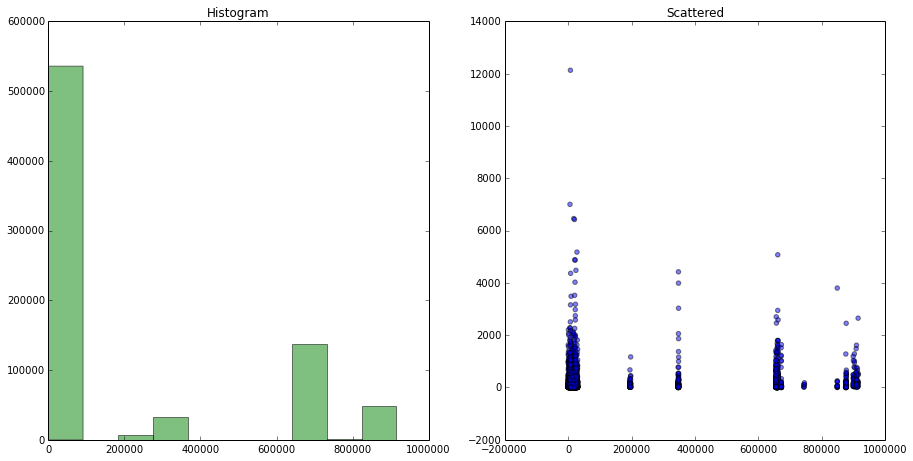

In [22]:
# Histogram / scatter plots of the above.
fig, axs = plt.subplots(1,2)

fig.set_figheight(7.5)
fig.set_figwidth(15)
#fig.align_ylabels

axs[0].hist(bond_ids_noNA, alpha=0.5, color='green')
axs[0].set_title("Histogram")

axs[1].scatter(bond_id_dict_noNA.keys(), bond_id_dict_noNA.values(), alpha=0.5)
axs[1].set_title("Scattered")

In [24]:
# Final Train: No NaN Values, and all bond_id instances > 25
clean_data = train_noNA[train_noNA.bond_id.isin(bondID_gt25_noNA.keys())]
clean_data.index = pd.RangeIndex(1, len(clean_data)+1)
clean_data.shape

(738520, 61)

# Splitting the data into test and train

In [26]:
# init dataframes
train_df_list = []; test1_df_list = []; test2_df_list = [];

# Populate dataframes
for bondID in sorted(list(set(clean_data.bond_id.tolist()))):
    
    df = clean_data[clean_data['bond_id'] == bondID]
    N  = len(df)
    
    train_df_list.append( df.iloc[:int(np.floor(0.7*N)), :] )
    test1_df_list.append( df.iloc[int(np.floor(0.7*N)):int(np.floor(0.85*N)), :] )
    test2_df_list.append( df.iloc[int(np.floor(0.85*N)):, :] )

train_df = pd.concat(train_df_list)
test1_df = pd.concat(test1_df_list)
test2_df = pd.concat(test2_df_list)

0
0
0


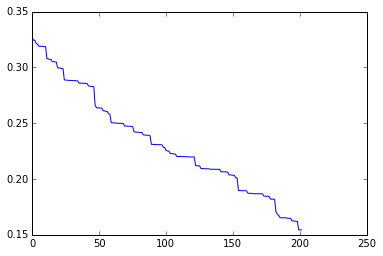

In [28]:
print(len(train_df)/len(clean_data));print(len(test1_df)/len(clean_data)); print(len(test2_df)/len(clean_data))
plt.plot(train_df[train_df['bond_id'] == 2].time_to_maturity.tolist())

In [30]:
def WEPS(weights, y_true, y_pred):
    return sum(np.multiply(weights, np.absolute(y_true-y_pred))) / sum(weights)

In [32]:
y_train = train_df.trade_price; X_train = train_df.drop('trade_price', axis=1)
y_test1 = test1_df.trade_price; X_test1 = test1_df.drop('trade_price', axis=1)
y_test2 = test2_df.trade_price; X_test2 = test2_df.drop('trade_price', axis=1)


In [34]:
y_train2 = pd.concat([y_train,y_test1]); X_train2 = pd.concat([X_train, X_test1])

## PCR 

In [57]:
from sklearn.decomposition import PCA
import timeit
start_time = timeit.default_timer()
pca_obj = PCA().fit(X_train)
transformed = pca_obj.transform(X_train)
elapsed = timeit.default_timer() - start_time
elapsed

11.668988943099976

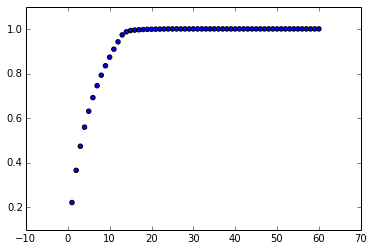

In [37]:
##Number of components to be used
total_variance = np.cumsum(pca_obj.explained_variance_ratio_)
k=range(1,61)
plt.scatter(k,total_variance)
## Using 23 components

In [38]:
## Using regression on first 23 transformed features
from sklearn.linear_model import LinearRegression
X_transformed_use = transformed[:,:23]
lm = LinearRegression().fit(X_transformed_use, y_train)

## Transform the test data 1
X_test_transformed = pca_obj.transform(X_test1)[:,:23]

##Predict
lm_y_hat_pcr = lm.predict(X_test_transformed)
lm_y_train_pcr = lm.predict(X_transformed_use)

In [39]:
## Calculating the errors
# 1. MSE
from sklearn.metrics import mean_squared_error
mse_pcr_train = mean_squared_error(lm_y_hat_pcr, y_test1)
mse_pcr_test = mean_squared_error(lm_y_train_pcr,y_train)

In [40]:
mse_pcr_test
WEPS(X_test1.weight, y_test1, lm_y_hat_pcr)

7.23572421676246

In [41]:
predictions = pd.DataFrame({"y_hat":lm_y_hat_pcr,"actual_y":y_test1})

Comments: Using 23 components gives disastourously high MSE, increasing components by even 2 (to 25) gives a much better MSE which can be lived with. Iterating over number of principal components and checking WEPS/MSE plot to see which gives the best performance in sense of reduction of error for both train and test data set.

In [42]:
k=61
s=1
mse_train_vec = np.zeros(k)
weps_train_vec = np.zeros(k)
mse_test_vec = np.zeros(k)
weps_test_vec = np.zeros(k)
for i in range(s+1,k):
    X_train_transformed = transformed[:,:i]
    X_test_transformed = pca_obj.transform(X_test1)[:,:i]
    lm = LinearRegression().fit(X_train_transformed, y_train)
    lm_y_test_pcr = lm.predict(X_test_transformed)
    lm_y_train_pcr = lm.predict(X_train_transformed)
    mse_train_vec[i] = mean_squared_error(lm_y_train_pcr,y_train)
    mse_test_vec[i] = mean_squared_error(lm_y_test_pcr,y_test1)
    weps_train_vec[i] = WEPS(X_train.weight, y_train, lm_y_train_pcr)
    weps_test_vec[i]=WEPS(X_test1.weight,y_test1,lm_y_test_pcr)
    
    

0

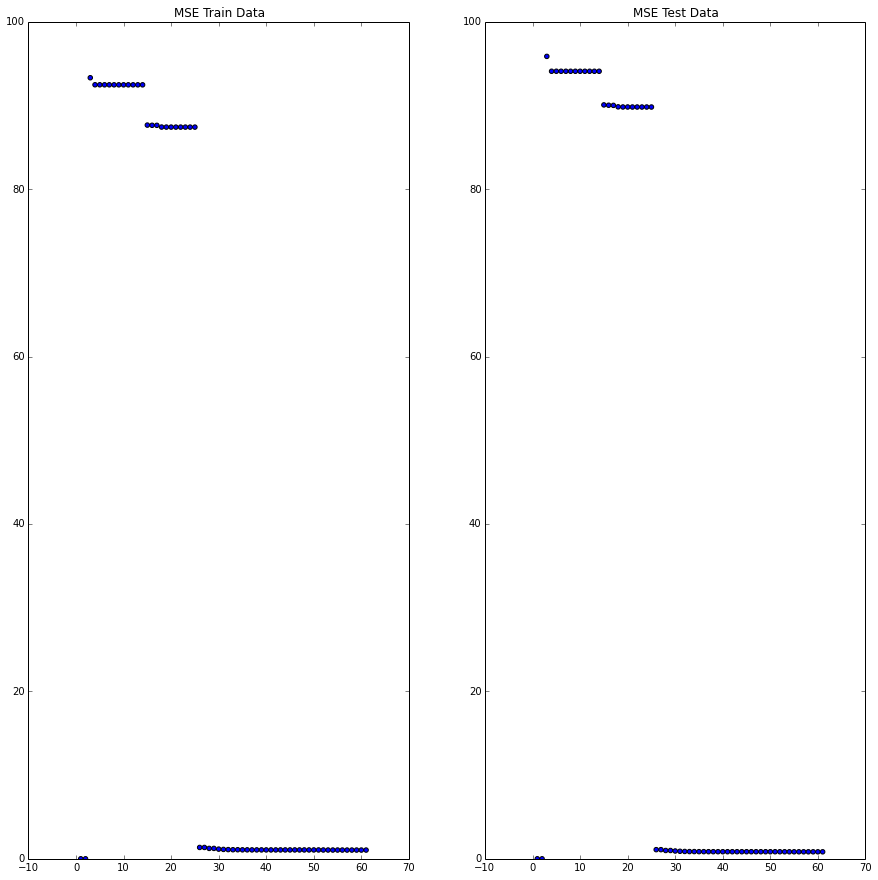

In [46]:
x_range = range(s,62)
fig, axs = plt.subplots(1,2, figsize = (15,15))
axs[0].set_ylim([0,100])
axs[0].scatter(x_range,mse_train_vec)
axs[0].set_title("MSE Train Data")
axs[1].set_ylim([0,100])
axs[1].scatter(x_range,mse_test_vec)
axs[1].set_title("MSE Test Data")

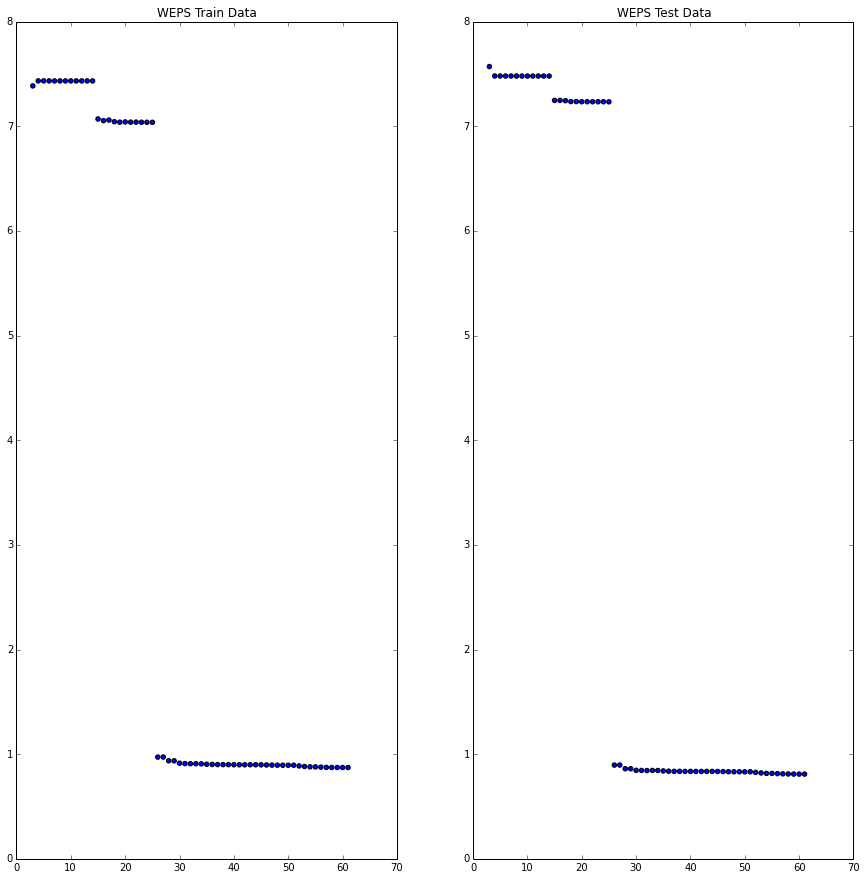

In [48]:
fig, axs = plt.subplots(1,2, figsize = (15,15))
axs[0].scatter(x_range[2:61],weps_train_vec[2:61])
axs[0].set_title("WEPS Train Data")
axs[1].scatter(x_range[2:61],weps_test_vec[2:61])
axs[1].set_title("WEPS Test Data")

In [55]:
weps_test_vec[25]
weps_train_vec[25]

0.9720983319405258

WEPS reduces to 0.8956 on testing dataset with 25 components. Training error:0.97209
Time taken to train: 12 s

## Running OLS with second training data set


In [58]:
start_time = timeit.default_timer()
pca_obj = PCA().fit(X_train2)
transformed = pca_obj.transform(X_train2)
elapsed = timeit.default_timer() - start_time
elapsed

18.34253692626953

In [59]:
X_transformed_use = transformed[:,:23]
lm = LinearRegression().fit(X_transformed_use, y_train2)

## Transform the test data 1
X_test_transformed = pca_obj.transform(X_test2)[:,:23]

##Predict
lm_y_hat_pcr = lm.predict(X_test_transformed)
lm_y_train_pcr = lm.predict(X_transformed_use)

In [60]:
mse_pcr_train = mean_squared_error(lm_y_hat_pcr, y_test2)
mse_pcr_test = mean_squared_error(lm_y_train_pcr,y_train2)

In [62]:
k=61
s=1
mse_train_vec = np.zeros(k)
weps_train_vec = np.zeros(k)
mse_test_vec = np.zeros(k)
weps_test_vec = np.zeros(k)
for i in range(s+1,k):
    X_train_transformed = transformed[:,:i]
    X_test_transformed = pca_obj.transform(X_test2)[:,:i]
    lm = LinearRegression().fit(X_train_transformed, y_train2)
    lm_y_test_pcr = lm.predict(X_test_transformed)
    lm_y_train_pcr = lm.predict(X_train_transformed)
    mse_train_vec[i] = mean_squared_error(lm_y_train_pcr,y_train2)
    mse_test_vec[i] = mean_squared_error(lm_y_test_pcr,y_test2)
    weps_train_vec[i] = WEPS(X_train2.weight, y_train2, lm_y_train_pcr)
    weps_test_vec[i]=WEPS(X_test2.weight,y_test2,lm_y_test_pcr)
    
    

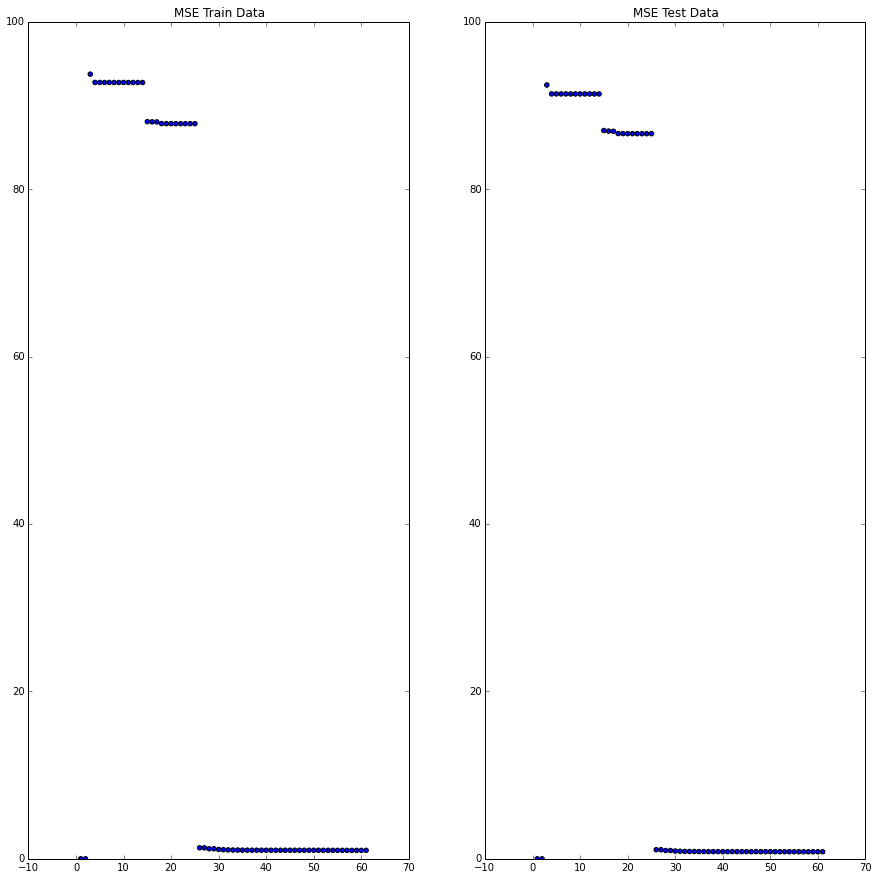

In [63]:
x_range = range(s,62)
fig, axs = plt.subplots(1,2, figsize = (15,15))
axs[0].set_ylim([0,100])
axs[0].scatter(x_range,mse_train_vec)
axs[0].set_title("MSE Train Data")
axs[1].set_ylim([0,100])
axs[1].scatter(x_range,mse_test_vec)
axs[1].set_title("MSE Test Data")

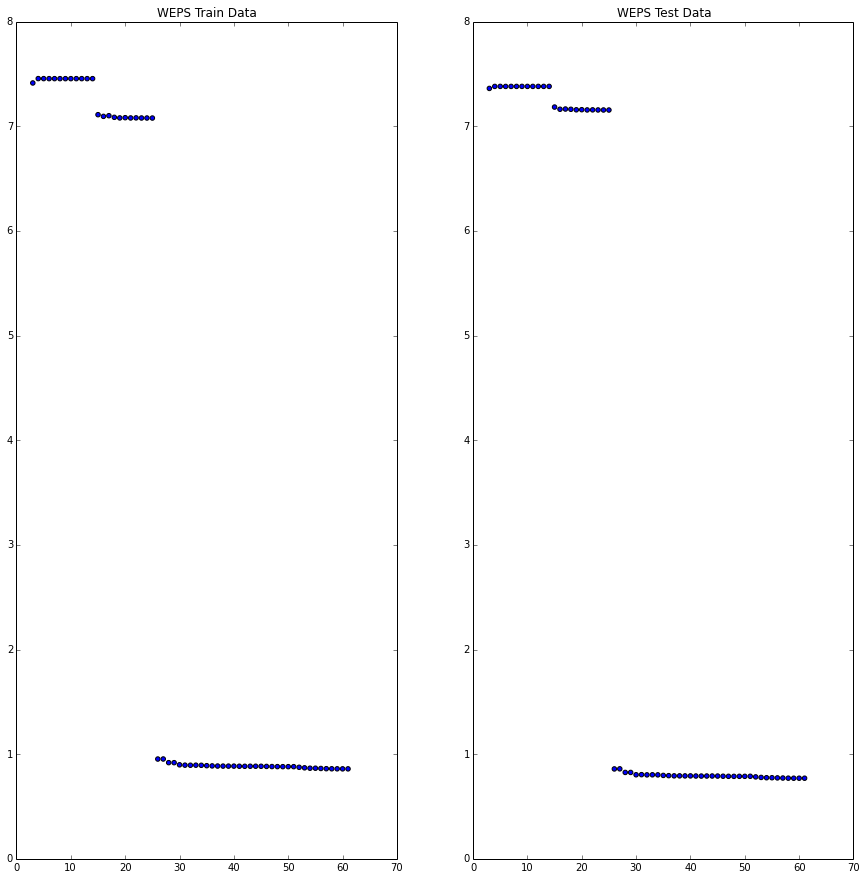

In [64]:
fig, axs = plt.subplots(1,2, figsize = (15,15))
axs[0].scatter(x_range[2:61],weps_train_vec[2:61])
axs[0].set_title("WEPS Train Data")
axs[1].scatter(x_range[2:61],weps_test_vec[2:61])
axs[1].set_title("WEPS Test Data")

In [67]:
weps_test_vec[25]
weps_train_vec[25]

0.953577450397973

WEPS reduces to 0.858 on testing dataset with 25 components. Training error:0.9535
Time taken to train: 18 s. At the expense of just 6s, a reduction in error can be seen in both training and test data set

## Running WLS

In [68]:
ws = X_train.weight
X_train_no_weights = X_train.drop('weight', axis=1)

## Run PCA again
start_time = timeit.default_timer()
pca_obj = PCA().fit(X_train_no_weights)
transformed = pca_obj.transform(X_train_no_weights)
elapsed = timeit.default_timer() - start_time
elapsed

9.644479990005493

In [70]:
X_transformed_use = transformed[:,:23]
#lm = LinearRegression().fit(X_transformed_use, y_train)
wls_reg = LinearRegression().fit(X_transformed_use, y_train, sample_weight=ws)
## Transform the test data 1
X_test_transformed = pca_obj.transform(X_test1.drop('weight', axis=1))[:,:23]

##Predict
wls_y_hat_pcr = wls_reg.predict(X_test_transformed)
wls_y_train_pcr = wls_reg.predict(X_transformed_use)

In [77]:
k=61
s=1
mse_train_vec = np.zeros(k)
weps_train_vec = np.zeros(k)
mse_test_vec = np.zeros(k)
weps_test_vec = np.zeros(k)
for i in range(s+1,k):
    X_train_transformed = transformed[:,:i]
    X_test_transformed = pca_obj.transform(X_test1.drop('weight', axis=1))[:,:i]
    wls = LinearRegression().fit(X_train_transformed, y_train,sample_weight=ws)
    wls_y_test_pcr = wls.predict(X_test_transformed)
    wls_y_train_pcr = wls.predict(X_train_transformed)
    mse_train_vec[i] = mean_squared_error(wls_y_train_pcr,y_train)
    mse_test_vec[i] = mean_squared_error(wls_y_test_pcr,y_test1)
    weps_train_vec[i] = WEPS(X_train.weight, y_train, wls_y_train_pcr)
    weps_test_vec[i]=WEPS(X_test1.weight,y_test1,wls_y_test_pcr)
    

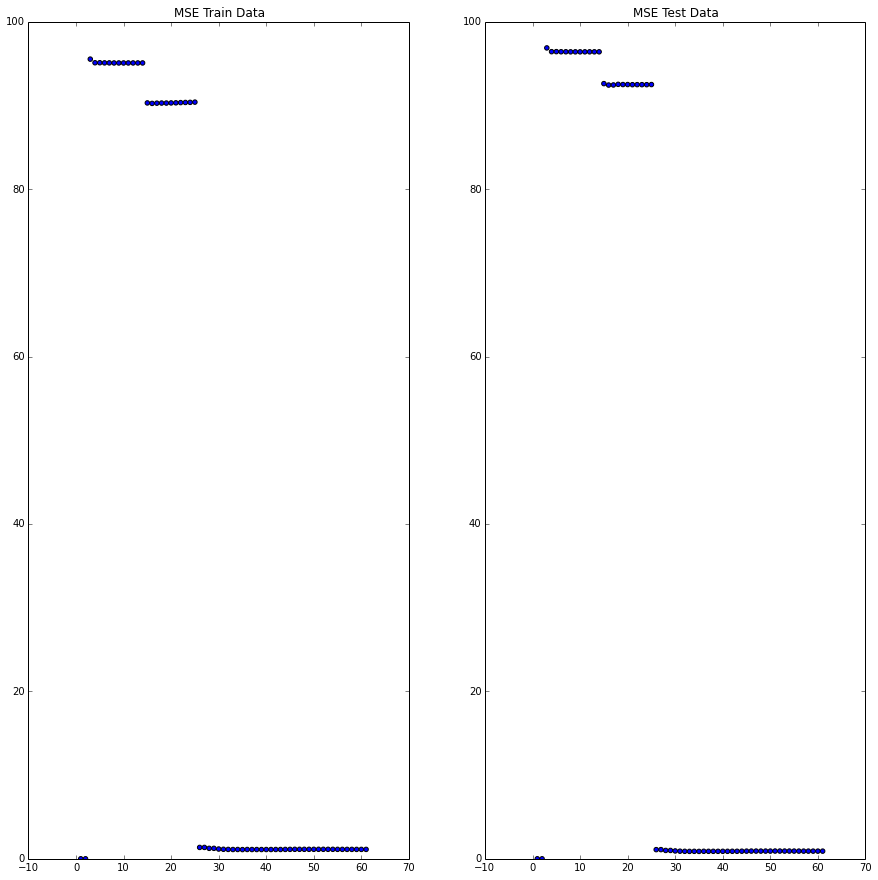

In [78]:
x_range = range(s,62)
fig, axs = plt.subplots(1,2, figsize = (15,15))
axs[0].set_ylim([0,100])
axs[0].scatter(x_range,mse_train_vec)
axs[0].set_title("MSE Train Data")
axs[1].set_ylim([0,100])
axs[1].scatter(x_range,mse_test_vec)
axs[1].set_title("MSE Test Data")

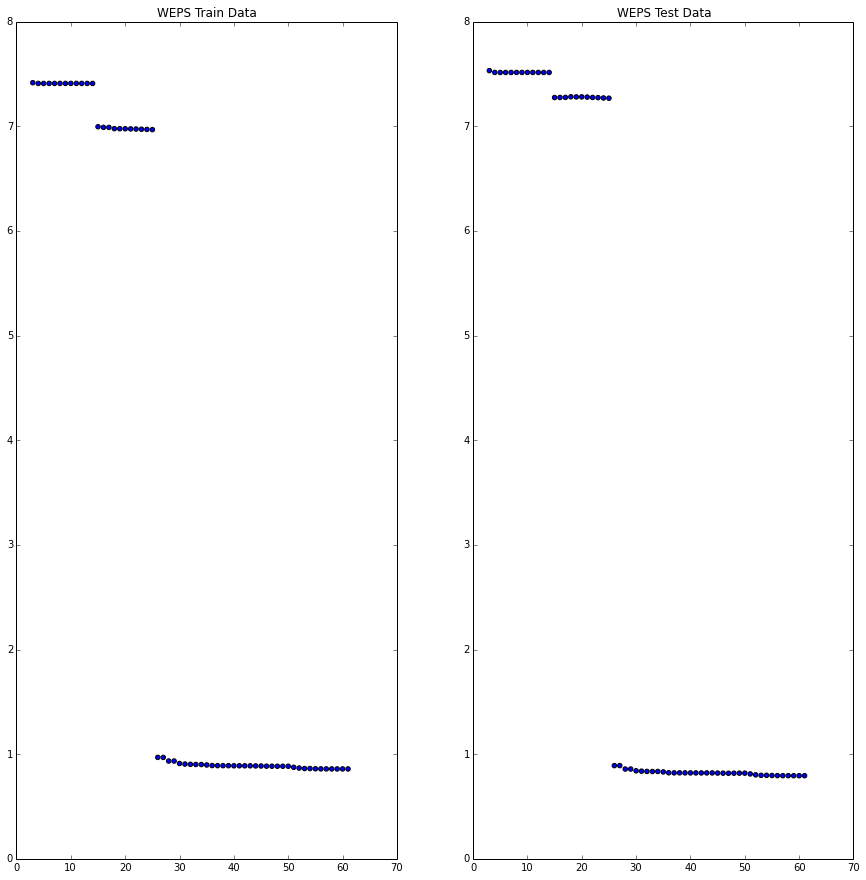

In [79]:
fig, axs = plt.subplots(1,2, figsize = (15,15))
axs[0].scatter(x_range[2:61],weps_train_vec[2:61])
axs[0].set_title("WEPS Train Data")
axs[1].scatter(x_range[2:61],weps_test_vec[2:61])
axs[1].set_title("WEPS Test Data")

In [81]:
weps_test_vec[25]
weps_train_vec[25]

0.8907226154390959

Time taken: 9.65s
Train Error: 0.9693
Test Error: 0.89

## Training data set-2


In [82]:
ws = X_train2.weight
X_train_no_weights = X_train2.drop('weight', axis=1)

## Run PCA again
start_time = timeit.default_timer()
pca_obj = PCA().fit(X_train_no_weights)
transformed = pca_obj.transform(X_train_no_weights)
elapsed = timeit.default_timer() - start_time
elapsed

12.030644178390503

In [83]:
X_transformed_use = transformed[:,:23]
#lm = LinearRegression().fit(X_transformed_use, y_train)
wls_reg = LinearRegression().fit(X_transformed_use, y_train2, sample_weight=ws)
## Transform the test data 1
X_test_transformed = pca_obj.transform(X_test2.drop('weight', axis=1))[:,:23]

##Predict
wls_y_hat_pcr = wls_reg.predict(X_test_transformed)
wls_y_train_pcr = wls_reg.predict(X_transformed_use)

In [85]:
k=61
s=1
mse_train_vec = np.zeros(k)
weps_train_vec = np.zeros(k)
mse_test_vec = np.zeros(k)
weps_test_vec = np.zeros(k)
for i in range(s+1,k):
    X_train_transformed = transformed[:,:i]
    X_test_transformed = pca_obj.transform(X_test2.drop('weight', axis=1))[:,:i]
    wls = LinearRegression().fit(X_train_transformed, y_train2,sample_weight=ws)
    wls_y_test_pcr = wls.predict(X_test_transformed)
    wls_y_train_pcr = wls.predict(X_train_transformed)
    mse_train_vec[i] = mean_squared_error(wls_y_train_pcr,y_train2)
    mse_test_vec[i] = mean_squared_error(wls_y_test_pcr,y_test2)
    weps_train_vec[i] = WEPS(X_train2.weight, y_train2, wls_y_train_pcr)
    weps_test_vec[i]=WEPS(X_test2.weight,y_test2,wls_y_test_pcr)

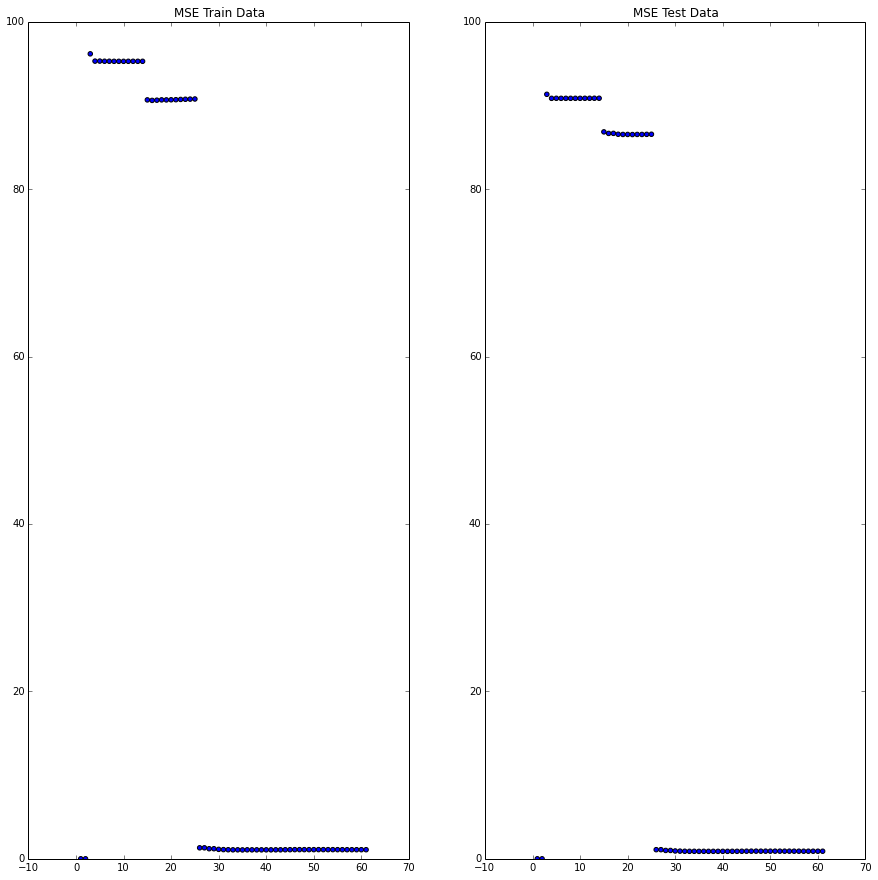

In [86]:
x_range = range(s,62)
fig, axs = plt.subplots(1,2, figsize = (15,15))
axs[0].set_ylim([0,100])
axs[0].scatter(x_range,mse_train_vec)
axs[0].set_title("MSE Train Data")
axs[1].set_ylim([0,100])
axs[1].scatter(x_range,mse_test_vec)
axs[1].set_title("MSE Test Data")

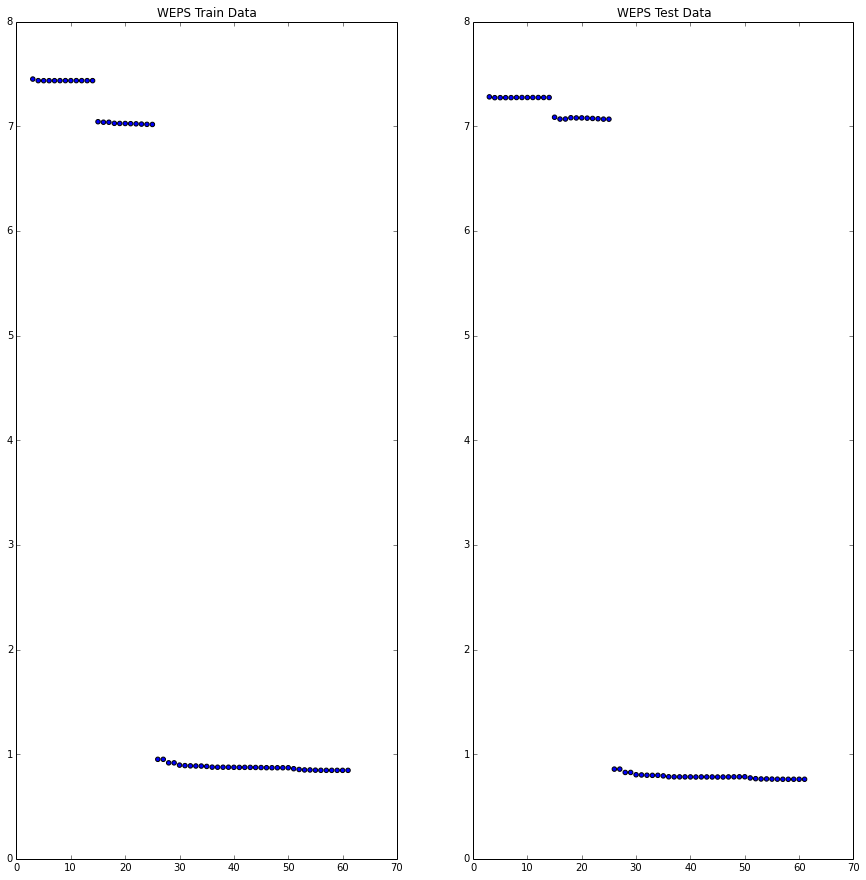

In [87]:
fig, axs = plt.subplots(1,2, figsize = (15,15))
axs[0].scatter(x_range[2:61],weps_train_vec[2:61])
axs[0].set_title("WEPS Train Data")
axs[1].scatter(x_range[2:61],weps_test_vec[2:61])
axs[1].set_title("WEPS Test Data")

In [89]:
weps_test_vec[25]
#weps_train_vec[25]

0.8572008452634353

Time: 12s
Train Error: 0.9501
Test Error: 0.857